# Semantic Analysis - RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#TRAINING ON RNN

"""
https://www.youtube.com/watch?v=kxeyoyrf2cM&t=1017s @9.10sec
"""

#Imports
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from collections import Counter
import pandas as pd
import json

#Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/CZ4034/RNN/clean_processed_flair_labels.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)

# # of rows = 5000, # of cols = 2
print(dataset.shape)

#Exploring the Dataset
print(dataset['flair_labels'].value_counts())

"""
NOTE: There exists an imabalnce between positiv eand negative labels, only 24% are negative.
Therefore, to address this issue we can do additional steps such as:

    • Finding the Text Similarity between the positive samples, so that there is no duplication
      of samples with the same semantic meaning.

    • Using SMOTE

    • Oversampling/Undersampling
"""

#Count all the unique words - input to fxn: column [series]
prev_list = []

for review in dataset.Review:
    string_list = review.split(' ')
    string_list += prev_list
    prev_list = string_list

counter = Counter(string_list)

#Getting the number of unique words
num_unique_words = len(counter)

#Getting the top 10 most commonly used words
most_common = counter.most_common(10)

"""
NOTE: Top 10 most common words are:
  1. skin - 4746
  2. product - 1677
  3. love - 1484
  4. use - 1337
  5. like - 1194
  6. really - 1146
  7. using - 1134
  8. face - 1089
  9. ive - 831
  10. great - 818
"""

#Splitting into trianing and validation splits
x_train, x_test, y_train, y_test = train_test_split(dataset['Review'], dataset['flair_labels'], test_size=0.2, random_state=42)
# Train - 4K , Test - 1K

#Convert from Series into Numpy Array
train_sentences = x_train.to_numpy()
train_labels = y_train.to_numpy()

test_sentences = x_test.to_numpy()
test_labels = y_test.to_numpy()

#Tokenization - vectorise a text corpus by converting text into a sequence of integers
#this also generates a word index
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

#writing the word index into a text file
"""
with open("/content/drive/MyDrive/CZ4034/RNN/cleaned_flair_labels.txt", 'w') as f:
    f.write(json.dumps(word_index))
"""

#Converting the text into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#Gettign the longest review
MAX_LEN = len(max(train_sequences))

#Padding the Sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

"""
NOTE: 
  • Train Padded Shape: (4000, 30)
  • Test Padded Shape: (1000, 30)
"""
#CREATING THE RNN
#------------------
model = Sequential()

#Embedding Layer
model.add(Embedding(num_unique_words, 32, input_length=MAX_LEN))
model.add(SimpleRNN(128, activation='tanh')) # # of outputs = size of hidden cell = 128
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

#Loss and Optimizer
loss = BinaryCrossentropy(from_logits=False) # cuz sigmoid activation fxn is used in the classificaiton layer
optimizer = Adam(lr=0.001)
metrics = ['accuracy']
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')

#Compiling
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#Training the Model
NUM_EPOCHS = 10
print("INFO: Started Training of RNN")
history = model.fit(train_padded, train_labels, epochs=NUM_EPOCHS, validation_data=(test_padded, test_labels), verbose=1, callbacks=[early_stopping])

(5000, 2)
1    4020
0     980
Name: flair_labels, dtype: int64
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 32)            225792    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               20608     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 246,529
Trainable params: 246,529
Non-trainable params: 0
_________________________________________________________________


None
INFO: Started Training of RNN
Epoch 1/10
125/125 [==============================] - 3s 13ms/step - loss: 0.4960 - accuracy: 0.8008 - val_loss: 0.4765 - val_accuracy: 0.8080
Epoch 2/10
125/125 [==============================] - 1s 12ms/step - loss: 0.3985 - accuracy: 0.8328 - val_loss: 0.4202 - val_accuracy: 0.8270
Epoch 3/10
125/125 [==============================] - 1s 12ms/step - loss: 0.2208 - accuracy: 0.9162 - val_loss: 0.4852 - val_accuracy: 0.8080
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 0.1177 - accuracy: 0.9590 - val_loss: 0.5514 - val_accuracy: 0.7890
Epoch 5/10
125/125 [==============================] - 1s 11ms/step - loss: 0.0618 - accuracy: 0.9820 - val_loss: 0.6128 - val_accuracy: 0.7770
Epoch 6/10
125/125 [==============================] - 2s 15ms/step - loss: 0.0483 - accuracy: 0.9840 - val_loss: 0.6639 - val_accuracy: 0.7730
Epoch 7/10
125/125 [==============================] - 2s 16ms/step - loss: 0.0446 - accuracy: 0.9837 - val_

In [15]:
#Save the model
model.save('/content/drive/MyDrive/CZ4034/RNN/RNN_try1.h5')

#Save the history of the model
with open('/content/drive/MyDrive/CZ4034/RNN/RNN_try1_history.txt', 'w') as f:
    f.write(str(history))

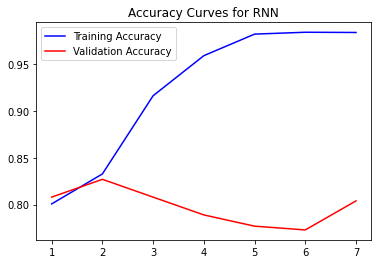

<Figure size 432x288 with 0 Axes>

In [16]:
#PLOTTING THE CURVES
epochs = range(1,8)

#Plotting the Accuracy Curves
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs,train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy Curves for RNN')
plt.legend()
plt.figure()
plt.savefig('/content/drive/MyDrive/CZ4034/RNN/RNN_try1_Accuracy.png')

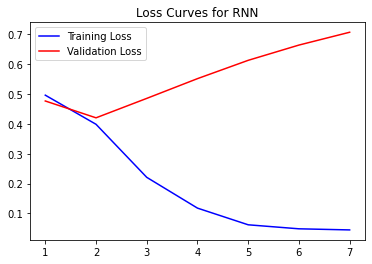

<Figure size 432x288 with 0 Axes>

In [17]:
#Plotting the Loss Curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs,train_loss, 'b', label='Training Loss')
plt.plot(epochs,val_loss, 'r', label='Validation Loss')
plt.title('Loss Curves for RNN')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CZ4034/RNN/RNN_try1_Loss.png')

From the Curves above, it can be seen that the training and validaiton metrics [both loss and accuracy] diverge after the second epoch. 

Some of the reasons for this are that:

1. The validation set is not representative of the training set. This means that the patterns the model is learning from the training set is not present in the validation set.

2. There is class imbalance in the dataset present overall

The chance for the divergence of this model occuring due to the class imbalance is higher than that of splitting of train-test split.

Hence, in order to solve Problem 2, we can implement text similarity. 

https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1

In [22]:
predictions = model.predict(test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

32/32 [==============================] - 0s 3ms/step


In [25]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

In [26]:
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

True Positives: 728
True Negatives: 76
False Positives: 121
False Negatives: 75


In [29]:
eval_metrics = model.evaluate(test_padded, test_labels)
print(f"Loss: {eval_metrics[0]}, Accuracy: {eval_metrics[1]*100}")

32/32 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.8040
Loss: 0.7068368196487427, Accuracy: 80.40000200271606


In [33]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=4ca990b820c7732ee81b6b228a925a9178618d5bd2fa57a0ffcf96b9acbf383b
  Stored in directory: /root/.cache/pip/wheels/fa/7a/e9/22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji


In [44]:
#Function to process the test sample in the same way as the data processing of training
import numpy as np
from cleantext import clean

#takes in a string(text) and returns a padded sequence 
def process_eval_sample(text):
  text = clean(text, no_emoji=True, no_punct=True, lower=True)
  text = text.split(" ")
  sentence = np.array(text)
  sequence = tokenizer.texts_to_sequences(sentence)
  padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

  return padded_sequence

#takes in a padded sequence and returns an integer (0 or 1) for the label
def predict_test_sample(padded_seq):
  predictions = model.predict(padded_seq)
  pred_values = [1 if p>0.5 else 0 for p in eval1_pred]
  pred_label = max(eval1_pred_values)

  return pred_label

In [45]:
eval1_text = "I have combination sensitive skin, even Cera Ve daily moisturizer causes irritation. This cream is the best I’ve ever felt AND reduces redness. Will definitely be restocking once my first order goes empty!"
gt1_label = '1'

eval1 = process_eval_sample(eval1_text)
eval1_label = predict_test_sample(eval1)

print(f"Eval Sample 1: {eval1_text}")
print(f"Ground Truth Label: {gt1_label}")
print(f"Predicted Label: {eval1_label}")

2/2 [==============================] - 0s 7ms/step
Eval Sample 1: I have combination sensitive skin, even Cera Ve daily moisturizer causes irritation. This cream is the best I’ve ever felt AND reduces redness. Will definitely be restocking once my first order goes empty!
Ground Truth Label: 1
Predicted Label: 1


In [46]:
eval2_text = "I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again."
gt2_label = '0'

eval2 = process_eval_sample(eval2_text)
eval2_label = predict_test_sample(eval2)

print(f"Eval Sample 2: {eval2_text}")
print(f"Ground Truth Label: {gt2_label}")
print(f"Predicted Label: {eval2_label}")

2/2 [==============================] - 0s 7ms/step
Eval Sample 2: I purchased this cream in hopes it would be good. It definitely hydrates my skin, but it does leave my face really shiny as if it’s oily. Not happy with this look and so I’ve ended up just using it only at night. Or, if I know I’m not venturing out anywhere, I’ll apply it on. May not purchase this again.
Ground Truth Label: 0
Predicted Label: 1


In [49]:
eval3_text = "No no and no. My eyes were on fire.I threw this away."
gt3_label = '0'

eval3 = process_eval_sample(eval3_text)
eval3_label = predict_test_sample(eval3)

print(f"Eval Sample 3: {eval3_text}")
print(f"Ground Truth Label: {gt3_label}")
print(f"Predicted Label: {eval3_label}")

1/1 [==============================] - 0s 26ms/step
Eval Sample 3: No no and no. My eyes were on fire.I threw this away.
Ground Truth Label: 0
Predicted Label: 1


From the above tests, we can also clearly see that the model is skewed towards the positive labels, so its more of Problem 2 than Problem 1. 

One Possible way to solve this is to check for text similarity and remove the samples with the same semantic meaning. 

Another way is to increase the number of negative labels samples.